# KSOM

## Importing Libraries

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Utility Function

In [2]:
def normalize(dataframe):
    temp_df = dataframe.iloc[:,:-1]
    for column_name in temp_df.columns:
        x_min = dataframe[column_name].min()
        x_max = dataframe[column_name].max()
        dataframe[column_name] = dataframe[column_name].map(lambda x: (x-x_min)/(x_max-x_min))
    return dataframe

def update_learning_rate(learning_rate,epoch):
    return learning_rate*math.exp(-epoch) #time constant = 1


def find_min(difference_list):
    min_r = 0
    min_c = 0
    for r in range(len(difference_list)):
        c = np.argmin(difference_list[r])
        if difference_list[min_r][min_c] > difference_list[r][c]:
            min_r = r
            min_c = c
    return min_r,min_c
            
def update_weights(record,weights,learning_rate,winner_neuron,neighbourhood_radius):
    new_weights = weights
    topological_func = math.exp(-(neighbourhood_radius**2)/2) #std deviation = 1
    low_row = winner_neuron[0] - math.floor(neighbourhood_radius)
    high_row = winner_neuron[0] + math.floor(neighbourhood_radius)
    low_col = winner_neuron[1] - math.floor(neighbourhood_radius)
    high_col = winner_neuron[1] + math.floor(neighbourhood_radius)
    if low_row < 0:
        low_row = 0
    if high_row >= weights.shape[0]:
        high_row = weights.shape[0] - 1
    
    
    if low_col < 0:
        low_col = 0
    if high_col >= weights.shape[1]:
        high_col = weights.shape[1] - 1
        
    for r in range(low_row,high_row+1):
        for c in range(low_col,high_col+1):
            for n in range(len(record)):
                new_weights[r][c][n] += learning_rate*topological_func*(record[n]-weights[r][c][n])
    return new_weights

## Reading data

In [3]:
df = pd.read_csv('bank_dataset.csv')

df = df.iloc[:,:-2]

print(df.shape)
print(df.columns)
df.head()

(10127, 21)
Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Dropping Unknown Values

In [4]:
df['Education_Level'].unique()

#unknown dropped df
u_df = df[df['Education_Level']!='Unknown']

u_df = u_df[u_df['Income_Category']!='Unknown']
u_df = u_df[u_df['Marital_Status']!='Unknown']
print(u_df.shape)
u_df.head()

(7081, 21)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,713061558,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,...,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311


## Dropping irrelevant columns like client number and attrition flag

In [5]:
operation_df = u_df.drop(['CLIENTNUM','Attrition_Flag',],axis=1)

print(operation_df.shape)
operation_df.head()

(7081, 19)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311


## Label Encoding the String Columns

In [6]:
le = LabelEncoder()
  
operation_df['Marital_Status']= le.fit_transform(operation_df['Marital_Status']) 
operation_df['Gender']= le.fit_transform(operation_df['Gender']) 
operation_df['Education_Level']= le.fit_transform(operation_df['Education_Level']) 
operation_df['Income_Category']= le.fit_transform(operation_df['Income_Category']) 
operation_df['Card_Category']= le.fit_transform(operation_df['Card_Category']) 
operation_df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,1,3,3,1,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,1,3,2,1,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
4,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
5,44,1,2,2,1,1,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311


In [7]:
print(u_df['Marital_Status'].unique())
print(operation_df['Marital_Status'].unique())

['Married' 'Single' 'Divorced']
[1 2 0]


In [8]:
print(u_df['Education_Level'].unique())
print(operation_df['Education_Level'].unique())

['High School' 'Graduate' 'Uneducated' 'College' 'Post-Graduate'
 'Doctorate']
[3 2 5 0 4 1]


In [9]:
print(u_df['Income_Category'].unique())
print(operation_df['Income_Category'].unique())

['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +']
[2 4 3 1 0]


In [10]:
print(u_df['Card_Category'].unique())
print(operation_df['Card_Category'].unique())

['Blue' 'Gold' 'Silver' 'Platinum']
[0 1 3 2]


## Normalize values

In [11]:
operation_df = normalize(operation_df)

## KSOM

In [18]:
input_features = len(operation_df.columns)
output_features = 10

In [19]:
weights = np.random.rand(output_features,output_features,input_features)

print(weights.shape)
print(weights)

(10, 10, 19)
[[[0.79224703 0.32599183 0.86395022 ... 0.86691292 0.13659215 0.65543552]
  [0.45281257 0.79866628 0.6716125  ... 0.7615336  0.89068003 0.05083909]
  [0.74802571 0.11150214 0.48981033 ... 0.8401907  0.74031751 0.78738434]
  ...
  [0.45406639 0.55424903 0.1368964  ... 0.52311002 0.90642048 0.00711638]
  [0.54017463 0.24195561 0.24937215 ... 0.52256508 0.23360949 0.27375916]
  [0.88145448 0.73384839 0.18305129 ... 0.21863044 0.98097119 0.99736177]]

 [[0.11070729 0.23904056 0.04392969 ... 0.91125088 0.48622268 0.51557948]
  [0.48384231 0.75086876 0.1254187  ... 0.74423183 0.72433011 0.65022275]
  [0.25955329 0.56519649 0.01623685 ... 0.24529728 0.66870199 0.82608613]
  ...
  [0.33349649 0.39206833 0.20166885 ... 0.36608617 0.0379053  0.74969592]
  [0.57569142 0.06350256 0.67857496 ... 0.96403496 0.82892222 0.98436717]
  [0.65573704 0.29310808 0.93380696 ... 0.62088182 0.02770476 0.89014422]]

 [[0.29605452 0.71278072 0.46272261 ... 0.96965814 0.28055065 0.1436349 ]
  [0.4861

In [20]:
operation_df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.404255,1.0,0.6,0.6,0.5,0.50,0.0,0.604651,0.8,0.166667,0.500000,0.340190,0.308701,0.345116,0.392994,0.036260,0.258065,0.437534,0.061
1,0.489362,0.0,1.0,0.4,1.0,1.00,0.0,0.720930,1.0,0.166667,0.333333,0.206112,0.343266,0.214093,0.453636,0.044667,0.185484,1.000000,0.105
2,0.531915,1.0,0.6,0.4,0.5,0.75,0.0,0.534884,0.6,0.166667,0.000000,0.059850,0.000000,0.098948,0.763615,0.078753,0.080645,0.628164,0.000
4,0.297872,1.0,0.6,1.0,0.5,0.50,0.0,0.186047,0.8,0.166667,0.000000,0.099091,0.000000,0.136557,0.640271,0.017501,0.145161,0.673129,0.000
5,0.382979,1.0,0.4,0.4,0.5,0.25,0.0,0.534884,0.4,0.166667,0.333333,0.077747,0.495431,0.079970,0.405063,0.033057,0.112903,0.227787,0.311


## Clustering with KSOM

In [21]:
cluster_victory_rate = np.zeros([output_features,output_features],int)

max_epochs = 100

for epoch in range(max_epochs):
    old_cluster = cluster_victory_rate
    cluster_victory_rate = np.zeros([output_features,output_features],int)
    learning_rate = 0.9
    print('Epoch number ',epoch)
    
    neighbourhood_radius = 3
    for index,record in operation_df.iterrows():
        record = list(record)
        difference_list = []
        for r in range(weights.shape[0]):
            difference_row = []
            for c in range(weights.shape[1]):
                difference = 0
                for i in range(len(record)):
                    difference += abs(list(weights[r][c])[i]-record[i])
                difference_row.append(difference) 
            difference_list.append(difference_row)
        
        winner_loc = find_min(difference_list)
        
        if(learning_rate != 0.0):
            weights = update_weights(record,weights,learning_rate,winner_loc,neighbourhood_radius)
            learning_rate = update_learning_rate(learning_rate,epoch)
        cluster_victory_rate[winner_loc[0]][winner_loc[1]] += 1
        neighbourhood_radius -= 0.1
        if neighbourhood_radius<=0:
            neighbourhood_radius = 0
    print('The cluster victory rate is: ')
    print(cluster_victory_rate)
    break_flag = True
    for index in range(len(cluster_victory_rate)):
        for jndex in range(len(cluster_victory_rate[0])):
            if (cluster_victory_rate[index][jndex] == old_cluster[index][jndex]):
                break_flag = True
            else:
                break_flag = False
                break
    if break_flag:
        break

print(weights)

Epoch number  0
The cluster victory rate is: 
[[  0   0   0   0   2   0   0   0 154   0]
 [  0   0   0 304   0   0   0   0   0   0]
 [ 62   0   0 311   0   0   0   0   0   0]
 [  0   0   0   0 302   0  40 126   0   0]
 [  0   0   0  80   0   0 327   2 230   0]
 [271 221   0   0   0   0   0   0   0   0]
 [304 309 466 415   0   0   0   0   0   0]
 [267 463 480 393   0   0   0   0   0   0]
 [  0 385 400 303   0   0   0   0   0   0]
 [272   0 192   0   0   0   0   0   0   0]]
Epoch number  1
The cluster victory rate is: 
[[   0    2    0    0   46    0    2    0  350    0]
 [   0    1   23  163    0    3    1    3    0    0]
 [ 633    0    0  277   25    0    1    0    0    1]
 [   0    0    0    0  316    1   82   39    0    1]
 [   0    1    5   68    0    1  122   18   66    0]
 [1362   73   30    2    7    0    4    8   10    0]
 [ 224  687   44  449    0   13    5    0    0    8]
 [ 158   60   89  115    0    0    5    0    3    0]
 [  70  169  107  152    4    0    1    0    0    0]


The cluster victory rate is: 
[[   1    5    0    4   39    0    2    0  364    0]
 [   0    2   56  291    0    3    1    4    0    0]
 [ 709    0    0  355   22    0    1    0    0    1]
 [   0    0    0    0  299    1   72   37    0    1]
 [   0    1   16   68    0    0  112   13   51    0]
 [1219   80   58    3    7    0    2    8    3    0]
 [ 197  685   42  499    0    8    5    0    0    8]
 [ 151   63   80  121    0    0    5    0    2    0]
 [  43  171   97  138    5    0    0    0    0    0]
 [ 695   18  136    0    1    0    0    0    0    0]]
Epoch number  16
The cluster victory rate is: 
[[   2    6    0    6   39    0    2    0  366    0]
 [   0    2   59  306    0    3    1    4    0    0]
 [ 703    0    0  362   20    0    1    0    0    1]
 [   0    0    0    0  298    1   72   36    0    1]
 [   0    1   16   69    0    0  112   12   51    0]
 [1215   79   58    3    7    0    2    9    3    0]
 [ 195  683   42  500    0    8    5    0    0    8]
 [ 151   63   80  120

The cluster victory rate is: 
[[   8    7    1   10   27    0    1    0  393    0]
 [   0    7   93  452    0    3    1    5    0    0]
 [ 701    0    1  416   15    0    1    0    0    1]
 [   0    0    0    0  273    1   62   34    0    1]
 [   2    2   28   68    0    0  108   10   44    0]
 [1052   83   67    5    8    0    1    9    0    0]
 [ 181  689   39  578    0    7    5    0    0    8]
 [ 144   67   75  134    1    0    5    0    2    0]
 [  13  171   89  130    5    0    0    0    0    0]
 [ 622    9  105    0    1    0    0    0    0    0]]
Epoch number  31
The cluster victory rate is: 
[[  10    7    1   12   27    0    1    0  399    0]
 [   0    7   97  465    0    3    1    5    0    0]
 [ 695    0    1  417   15    0    1    0    0    1]
 [   0    0    0    0  271    1   60   34    0    1]
 [   3    2   29   69    0    0  107   10   44    0]
 [1035   85   68    5    8    0    1    9    0    0]
 [ 181  692   39  580    0    7    5    0    0    8]
 [ 144   68   73  134

The cluster victory rate is: 
[[ 26  10   1  25  26   0   2   0 423   0]
 [  0  10 144 587   0   3   1   6   0   0]
 [649   0   5 407  10   0   1   0   0   1]
 [  0   0   0   1 243   2  49  35   0   1]
 [  5   1  34  70   0   0 105  11  42   0]
 [841  96  85   6   7   0   0  14   0   0]
 [172 750  34 653   0   6   5   0   0   8]
 [134  71  76 160   1   0   5   0   2   0]
 [  1 174  87 125   8   0   0   0   0   0]
 [539   7  77   0   1   0   0   0   0   0]]
Epoch number  48
The cluster victory rate is: 
[[ 27  10   1  25  26   0   2   0 426   0]
 [  0  10 146 589   0   3   1   6   0   0]
 [647   0   5 409  10   0   1   0   0   1]
 [  0   0   0   0 242   2  49  35   0   1]
 [  5   1  36  70   0   0 105  11  42   0]
 [831  95  84   6   7   0   1  14   0   0]
 [172 752  34 657   0   6   5   0   0   8]
 [131  71  77 162   1   0   5   0   2   0]
 [  1 174  87 125   8   0   0   0   0   0]
 [538   7  75   0   1   0   0   0   0   0]]
Epoch number  49
The cluster victory rate is: 
[[ 29  10   1 

## Plotting the clusters

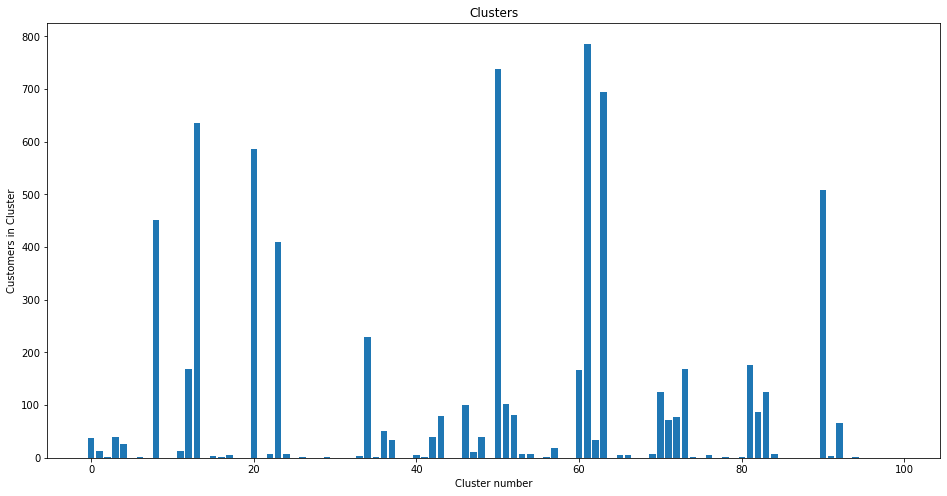

In [22]:
plt.figure(figsize=(16,8))

unpack_cluster_victory = []

for rate in cluster_victory_rate:
    for entry in rate:
        unpack_cluster_victory.append(entry)

plt.bar(range(100),unpack_cluster_victory)
plt.ylabel('Customers in Cluster')
plt.xlabel('Cluster number')
plt.title('Clusters')
plt.show()

In [23]:
cluster_victory_rate = np.zeros([output_features,output_features],int)

for index,record in operation_df.iterrows():
    record = list(record)
    difference_list = []
    for r in range(weights.shape[0]):
        difference_row = []
        for c in range(weights.shape[1]):
            difference = 0
            for i in range(len(record)):
                difference += abs(list(weights[r][c])[i]-record[i])
            difference_row.append(difference) 
        difference_list.append(difference_row)
    winner_loc = find_min(difference_list)
    cluster_victory_rate[winner_loc[0]][winner_loc[1]] += 1
    
print('The cluster victory rate is: ')
print(cluster_victory_rate)

print(weights)

The cluster victory rate is: 
[[ 38  12   1  39  26   0   2   0 451   0]
 [  0  12 168 635   0   3   1   6   0   0]
 [586   0   7 409   8   0   1   0   0   1]
 [  0   0   0   4 229   2  50  34   0   0]
 [  5   1  39  79   0   0 101  11  40   0]
 [738 103  82   7   8   0   1  18   0   0]
 [166 786  34 694   0   5   5   0   0   8]
 [124  71  78 169   1   0   5   0   2   0]
 [  1 176  86 124   8   0   0   0   0   0]
 [509   4  66   0   1   0   0   0   0   0]]
[[[6.18716249e-01 6.27444571e-01 7.45897471e-01 ... 5.94603139e-01
   2.71189392e-01 3.89571956e-01]
  [4.29844171e-01 8.93270341e-01 6.37962729e-01 ... 5.21782943e-01
   6.82651349e-01 5.42329556e-02]
  [5.61358025e-01 5.94284725e-01 5.60593853e-01 ... 5.11309490e-01
   5.67896777e-01 3.93316511e-01]
  ...
  [4.54066393e-01 5.54249033e-01 1.36896396e-01 ... 5.23110021e-01
   9.06420480e-01 7.11638465e-03]
  [1.86114154e-01 1.00000000e-13 2.05961616e-01 ... 8.84043014e-01
   2.01437505e-01 2.10772955e-01]
  [8.81454479e-01 7.33848391

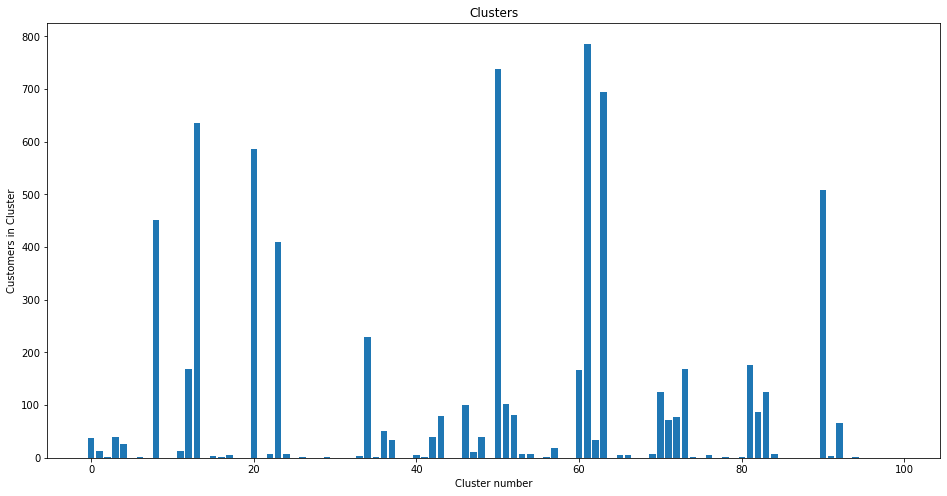

In [24]:
plt.figure(figsize=(16,8))

unpack_cluster_victory = []

for rate in cluster_victory_rate:
    for entry in rate:
        unpack_cluster_victory.append(entry)

plt.bar(range(100),unpack_cluster_victory)
plt.ylabel('Customers in Cluster')
plt.xlabel('Cluster number')
plt.title('Clusters')
plt.show()